The aim of notebook it to predict total Walmart weekls sales of 8 weeks using prophet

In [122]:
#importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [123]:
# loadinging data into dataframe
training_df = pd.read_csv(r"walmart_sales_data.csv")

In [124]:
# Spot Checks
training_df.head(8)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False


In [125]:
#info
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


Since there are multiple Stores and Departments, I will consolidate the weekly sales by the week

In [126]:
# grouping by Date and IsHoliday and aggregating Weekly Sales
weekly_sales_df = training_df.groupby(["Date", "IsHoliday"]).agg({"Weekly_Sales": "sum"}).reset_index()

In [127]:
#Spot Checks
weekly_sales_df.head()

,Date,IsHoliday,Weekly_Sales
0,2010-02-05,False,49750740.50
1,2010-02-12,True,48336677.63
2,2010-02-19,False,48276993.78
3,2010-02-26,False,43968571.13
4,2010-03-05,False,46871470.30


Converting "Date" column to date type

In [128]:

weekly_sales_df['Date'] = pd.to_datetime(weekly_sales_df['Date'])

Plotting Weekly Data v Monthly Rolling Average

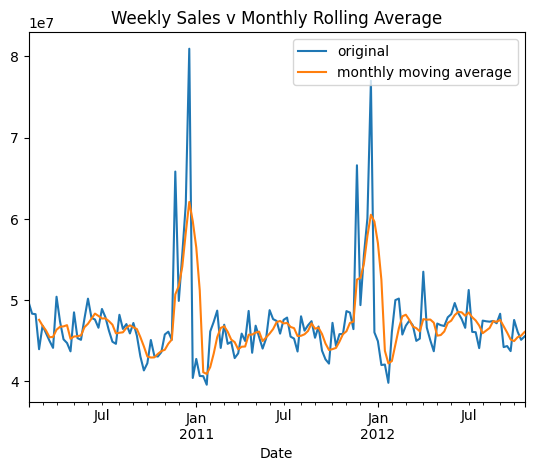

In [129]:
fig, ax = plt.subplots()
weekly_sales_df.set_index("Date")['Weekly_Sales'].plot(ax=ax, label='original')
weekly_sales_df.set_index("Date")['Weekly_Sales'].rolling(window=4).mean().plot(ax=ax, label='monthly moving average')
plt.title("Weekly Sales v Monthly Rolling Average")
plt.legend()
plt.show()

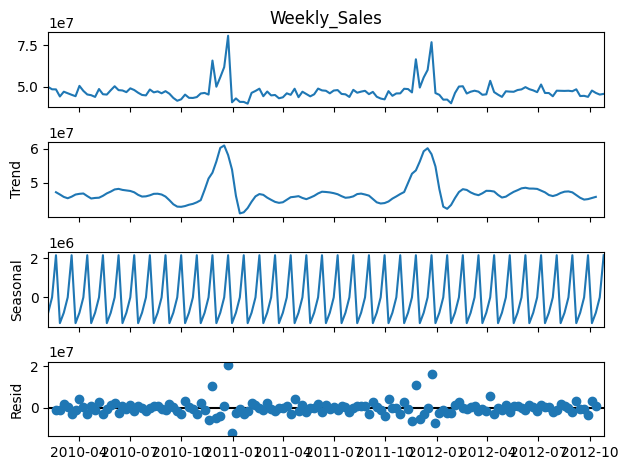

In [130]:
#Seasonal Decompose
seasonal_decompose(weekly_sales_df.set_index("Date")['Weekly_Sales'], period=4).plot();

Looking at the visuals, there is no upward or downard trend and the monthly seasonality plots  most of the points around the mean in the resid plot. There are some spikes which could be summer and holiday sales.

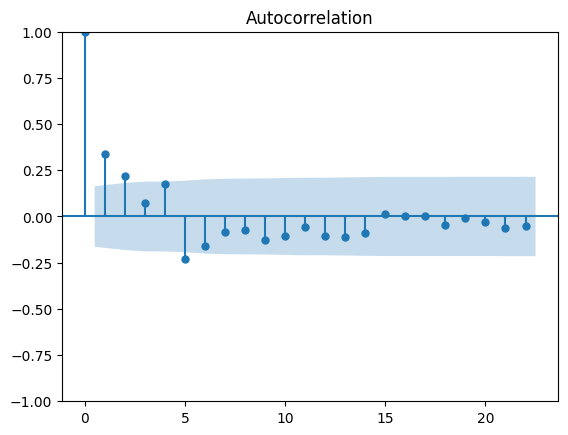

In [131]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(weekly_sales_df['Weekly_Sales']);

Autocorrelation shows little significant correlation

Splitting Data and leaving the last 8 weeks for testing

In [132]:
#selecting data before the last 4 weeks of the dataset as the training set
training_data = weekly_sales_df[weekly_sales_df['Date']<'2012-07-13']

In [133]:
#spot check
training_data.tail(10)

,Date,IsHoliday,Weekly_Sales
117,2012-05-04,False,47124197.93
118,2012-05-11,False,46925878.99
119,2012-05-18,False,46823939.22
120,2012-05-25,False,47892463.31
121,2012-06-01,False,48281649.72
122,2012-06-08,False,49651171.78
123,2012-06-15,False,48412110.70
124,2012-06-22,False,47668284.97
125,2012-06-29,False,46597112.12
126,2012-07-06,False,51253021.88


In [134]:
# selecting the last 4 weeks of the dataset as the test set
test_data = weekly_sales_df[weekly_sales_df['Date']>="2012-07-13"]

In [135]:
# spot check
test_data.head()

,Date,IsHoliday,Weekly_Sales
127,2012-07-13,False,46099732.10
128,2012-07-20,False,46059543.45
129,2012-07-27,False,44097154.97
130,2012-08-03,False,47485899.56
131,2012-08-10,False,47403451.04


Training the data using Prophet

In [136]:
# first rename columns

prophet_training_data = training_data.rename(columns={'Date':'ds', "Weekly_Sales":"y"})

prophet_test_data = test_data.rename(columns={'Date':'ds', "Weekly_Sales":"y"})

In [137]:
# Spot Checks
prophet_training_data.head()

,ds,IsHoliday,y
0,2010-02-05,False,49750740.50
1,2010-02-12,True,48336677.63
2,2010-02-19,False,48276993.78
3,2010-02-26,False,43968571.13
4,2010-03-05,False,46871470.30


Training the Model

In [138]:
model = Prophet()
model.add_regressor("IsHoliday") #asking the model to consider holidays
model.fit(prophet_training_data)

10:21:44 - cmdstanpy - INFO - Chain [1] start processing


10:21:44 - cmdstanpy - INFO - Chain [1] done processing


Predicting the next 4 weeks

In [139]:
future = model.make_future_dataframe(periods=16, freq='W')
future = future.merge(weekly_sales_df[[ "Date","IsHoliday"]], how='left', left_on='ds', right_on='Date').fillna({"IsHoliday":0})

prophet_forecast = model.predict(future)

In [140]:
future.head(5)

,ds,Date,IsHoliday
0,2010-02-05,2010-02-05,False
1,2010-02-12,2010-02-12,True
2,2010-02-19,2010-02-19,False
3,2010-02-26,2010-02-26,False
4,2010-03-05,2010-03-05,False


Evaluating Results

In [141]:
prophet_test_data['yhat'] = prophet_forecast['yhat']

In [142]:
prophet_test_data.head()

,ds,IsHoliday,y,yhat
127,2012-07-13,False,46099732.10,4.750530e+07
128,2012-07-20,False,46059543.45,4.698410e+07
129,2012-07-27,False,44097154.97,4.685795e+07
130,2012-08-03,False,47485899.56,4.677602e+07
131,2012-08-10,False,47403451.04,4.666691e+07


In [143]:
prophet_test_data = prophet_test_data.rename(columns={'y': 'Actual', 'yhat': 'Predicted'})

<Axes: xlabel='ds'>

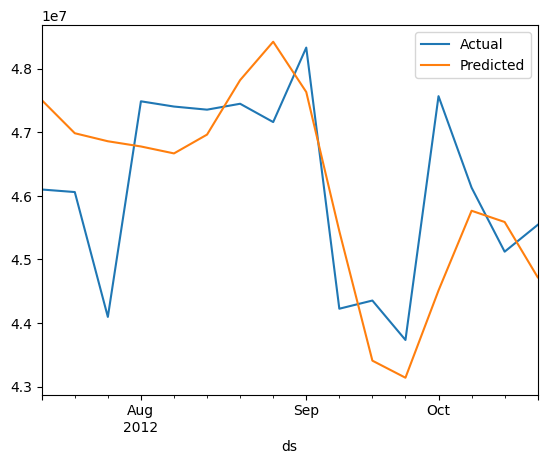

In [144]:
prophet_test_data.set_index("ds")[['Actual', 'Predicted']].plot()

In [145]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

In [146]:
print("MAE:",mae(prophet_test_data['Actual'], prophet_test_data['Predicted']))
print("MAPE:",round(mape(prophet_test_data['Actual'], prophet_test_data['Predicted'])*100,2), "%")

MAE: 1045356.1874882174
MAPE: 2.27 %


In [147]:
training_data.head()

,Date,IsHoliday,Weekly_Sales
0,2010-02-05,False,49750740.50
1,2010-02-12,True,48336677.63
2,2010-02-19,False,48276993.78
3,2010-02-26,False,43968571.13
4,2010-03-05,False,46871470.30


Prophet Hyperparamet Tuning

In [148]:
# Python
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

cutoffs = pd.to_datetime(['2010-12-12', '2011-12-11', '2012-02-10'])
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_training_data)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

10:21:44 - cmdstanpy - INFO - Chain [1] start processing


10:21:44 - cmdstanpy - INFO - Chain [1] done processing
10:21:44 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:21:44 - cmdstanpy - INFO - Chain [1] start processing
10:21:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
10:21:45 - cmdstanpy - INFO - Chain [1] start processing
10:21:45 - cmdstanpy - INFO - Chain [1] start processing
10:21:45 - cmdstanpy - INFO - Chain [1] start processing
10:21:45 - cmdstanpy - INFO - Chain [1] done processing
10:21:45 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:21:45 - cmdstanpy - INFO - Chain [1] start processing
10:21:45 - cmdstanpy - INFO - Chain [1] done processing
10:21:45 - cmdstanpy - INFO - Chain [1] done processing
10:21:45 - cmdstanpy - INFO - Chain [1] done proc

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  1.256165e+07
1                     0.001                     0.10  1.255217e+07
2                     0.001                     1.00  2.640395e+07
3                     0.001                    10.00  7.025890e+07
4                     0.010                     0.01  1.264112e+07
5                     0.010                     0.10  1.242212e+07
6                     0.010                     1.00  2.994154e+07
7                     0.010                    10.00  7.668274e+07
8                     0.100                     0.01  1.222809e+07
9                     0.100                     0.10  1.237137e+07
10                    0.100                     1.00  3.134089e+07
11                    0.100                    10.00  7.187818e+07
12                    0.500                     0.01  1.198048e+07
13                    0.500                     0.10  1.237711

10:21:59 - cmdstanpy - INFO - Chain [1] done processing


In [149]:
# Selecting the best parameters
prophet_best_results =tuning_results.sort_values(by='rmse', ascending=True).head(1)
prophet_best_results

,changepoint_prior_scale,seasonality_prior_scale,rmse
12,0.5,0.01,1.198048e+07


In [150]:
# Calling the prophet model with the best parameters
prophet_best_model = Prophet(changepoint_prior_scale=prophet_best_results['changepoint_prior_scale'],
                              seasonality_prior_scale=prophet_best_results['seasonality_prior_scale'])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:128: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.seasonality_prior_scale = float(seasonality_prior_scale)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:129: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.changepoint_prior_scale = float(changepoint_prior_scale)


In [151]:
# fitting the training data with the best model
prophet_best_model.fit(prophet_training_data)

10:21:59 - cmdstanpy - INFO - Chain [1] start processing
10:21:59 - cmdstanpy - INFO - Chain [1] done processing


In [152]:
# Setting parameters for the future
prophet_best_future = prophet_best_model.make_future_dataframe(periods=16, freq='W')

In [153]:
# merging the future dataframe with the date and isholiday columns of the weekly sales dataframe
prophet_best_future = prophet_best_future.merge(weekly_sales_df[[ "Date","IsHoliday"]], how='left', left_on='ds', right_on='Date').fillna({"IsHoliday":0})

In [154]:
# making prediction
prophet_best_forecast = prophet_best_model.predict(prophet_best_future)

In [155]:
# Adding the predicted data as a column of the test data set
prophet_test_data['best_model_Predicted'] = prophet_best_forecast['yhat']

In [156]:
# renaming column y to Actual
prophet_test_data = prophet_test_data.rename(columns={'y': 'Actual'})

<Axes: xlabel='ds'>

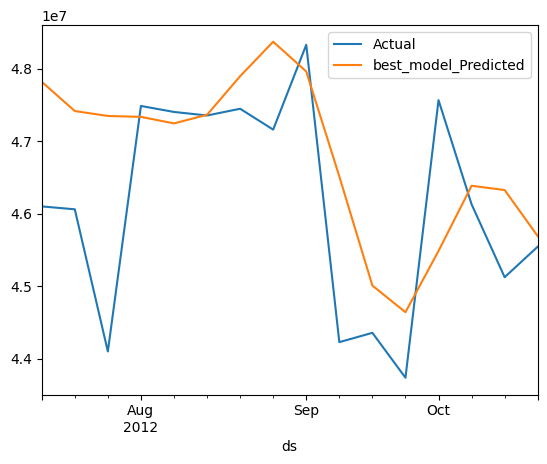

In [157]:
#Ploting the predicted v actual data
prophet_test_data.set_index('ds')[['Actual','best_model_Predicted']].plot()

In [159]:
print("MAE:",mae(prophet_test_data['Actual'], prophet_test_data['best_model_Predicted']))
print("MAPE:",round(mape(prophet_test_data['Actual'], prophet_test_data['best_model_Predicted'])*100,2), "%")

MAE: 1012977.8789358535
MAPE: 2.23 %


### Building a Forecasting Model using Linear Regression

In [160]:
#loading dataframe
training_df = pd.read_csv(r"walmart_sales_data.csv")

In [161]:
#spot checks
training_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [162]:
#selecting useful colmns
lr_data = training_df[['Date', 'Weekly_Sales']]

In [163]:
#Aggregating weekly sales
lr_data = lr_data.groupby('Date').agg({'Weekly_Sales': 'sum'}).reset_index()

In [164]:
#spot checks
lr_data.head()

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


In [165]:
#Adding trend data
lr_data['trend'] = np.arange(len(lr_data))

In [166]:
#setting "Date" column as Datetime format
lr_data['Date'] = pd.to_datetime(lr_data['Date'])

# creating week column
lr_data['week'] = lr_data['Date'].dt.isocalendar().week

# Verify
print(lr_data[['Date', 'week']].tail()) 

          Date  week
138 2012-09-28    39
139 2012-10-05    40
140 2012-10-12    41
141 2012-10-19    42
142 2012-10-26    43


In [167]:
#Converting Week column as string type
lr_data['week'] = lr_data['week'].astype(str)

In [168]:
#Creating Weekly dummies
lr_data = pd.get_dummies(lr_data, drop_first=True)
lr_data.head()

,Date,Weekly_Sales,trend,week_10,week_11,week_12,week_13,week_14,week_15,week_16,...,week_48,week_49,week_5,week_50,week_51,week_52,week_6,week_7,week_8,week_9
0,2010-02-05,49750740.50,0,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,2010-02-12,48336677.63,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,2010-02-19,48276993.78,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2010-02-26,43968571.13,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,2010-03-05,46871470.30,4,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [169]:
#setting each boolean column as INT type
for col in lr_data.columns:
    if lr_data[col].dtype == bool:
        lr_data[col] = lr_data[col].astype(int)

In [170]:
#Spot Checks
lr_data.head()

,Date,Weekly_Sales,trend,week_10,week_11,week_12,week_13,week_14,week_15,week_16,...,week_48,week_49,week_5,week_50,week_51,week_52,week_6,week_7,week_8,week_9
0,2010-02-05,49750740.50,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2010-02-12,48336677.63,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2010-02-19,48276993.78,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2010-02-26,43968571.13,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2010-03-05,46871470.30,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Splitting Data into Training and Test Sets

In [171]:
training_lr = lr_data[lr_data['Date']<'2012-07-13']
test_lr = lr_data[lr_data['Date']>='2012-07-13']

In [172]:
#Spot Checks
training_lr.tail()

,Date,Weekly_Sales,trend,week_10,week_11,week_12,week_13,week_14,week_15,week_16,...,week_48,week_49,week_5,week_50,week_51,week_52,week_6,week_7,week_8,week_9
122,2012-06-08,49651171.78,122,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,2012-06-15,48412110.70,123,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,2012-06-22,47668284.97,124,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,2012-06-29,46597112.12,125,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,2012-07-06,51253021.88,126,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
# Creatining X and y sets and adding a constant to the X data
import statsmodels.api as sm

y = training_lr['Weekly_Sales']
X = sm.add_constant(training_lr.iloc[:,2:])

In [174]:
# fitting the data using OLS
model = sm.OLS(y,X).fit()

In [175]:
# Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     34.23
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           9.58e-36
Time:                        10:22:29   Log-Likelihood:                -1951.8
No. Observations:                 127   AIC:                             4010.
Df Residuals:                      74   BIC:                             4160.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.329e+07   1.09e+06     39.576      0.000    4.11e+07    4.55e+07
trend       7713.8382   3703.123      2.083      0.041     335.204    1.51e+04
week_10     2.277e+06   1.37e+06      1.663      0.100   -4.51e+05       5e+06
week_11     1.845e+06   1.37e+06      1.348      0.182   -8.82e+05    4.57e+06
week_12     2.514e+05   1.37e+06      0.184      0.855   -2.48e+06    2.98e+06
week_13     2.628e+06   1.37e+06      1.920      0.059   -9.87e+04    5.35e+06
week_14     5.153e+06   1.37e+06      3.766      0.000    2.43e+06    7.88e+06
week_15     1.822e+06   1.37e+06      1.332      0.187   -9.03e+05    4.55e+06
week_16      2.38e+06   1.37e+06      1.740      0.086   -3.45e+05    5.11e+06
week_17    -1.378e+05   1.37e+06     -0.101      0.920   -2.86e+06    2.59e+06
week_18       3.7e+06   1.37e+06      2.706      0.008    9.75e+05    6.43e+06
week_19     2.097e+06   1.37e+06      1.533      0.129   -6.28e+05    4.82e+06
week_2     -2.525e+06    1.5e+06     -1.686      0.096   -5.51e+06    4.59e+05
week_20     1.519e+06   1.37e+06      1.110      0.270   -1.21e+06    4.24e+06
week_21     3.162e+06   1.37e+06      2.312      0.024    4.37e+05    5.89e+06
week_22     5.254e+06   1.37e+06      3.842      0.000    2.53e+06    7.98e+06
week_23     4.548e+06   1.37e+06      3.326      0.001    1.82e+06    7.27e+06
week_24     3.985e+06   1.37e+06      2.914      0.005    1.26e+06    6.71e+06
week_25      2.87e+06   1.37e+06      2.099      0.039    1.46e+05    5.59e+06
week_26      3.84e+06   1.37e+06      2.808      0.006    1.12e+06    6.56e+06
week_27     5.138e+06   1.37e+06      3.758      0.000    2.41e+06    7.86e+06
week_28     2.207e+06    1.5e+06      1.471      0.146   -7.83e+05     5.2e+06
week_29     1.401e+06    1.5e+06      0.934      0.353   -1.59e+06    4.39e+06
week_3     -2.513e+06    1.5e+06     -1.678      0.098    -5.5e+06    4.71e+05
week_30     4.686e+05    1.5e+06      0.312      0.756   -2.52e+06    3.46e+06
week_31     4.414e+06    1.5e+06      2.943      0.004    1.43e+06     7.4e+06
week_32     2.653e+06    1.5e+06      1.769      0.081   -3.35e+05    5.64e+06
week_33     3.278e+06    1.5e+06      2.186      0.032     2.9e+05    6.27e+06
week_34     2.944e+06    1.5e+06      1.964      0.053   -4.34e+04    5.93e+06
week_35     2.559e+06    1.5e+06      1.707      0.092   -4.29e+05    5.55e+06
week_36     2.464e+06    1.5e+06      1.644      0.104   -5.23e+05    5.45e+06
week_37    -3.048e+05    1.5e+06     -0.203      0.839   -3.29e+06    2.68e+06
week_38    -1.712e+06    1.5e+06     -1.142      0.257    -4.7e+06    1.27e+06
week_39     -1.54e+06    1.5e+06     -1.027      0.308   -4.53e+06    1.45e+06
week_4     -4.171e+06    1.5e+06     -2.785      0.007   -7.16e+06   -1.19e+06
week_40     2.392e+06    1.5e+06      1.596      0.115   -5.94e+05    5.38e+06
we

In [176]:
#Spot Checks
test_lr.head()

,Date,Weekly_Sales,trend,week_10,week_11,week_12,week_13,week_14,week_15,week_16,...,week_48,week_49,week_5,week_50,week_51,week_52,week_6,week_7,week_8,week_9
127,2012-07-13,46099732.10,127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,2012-07-20,46059543.45,128,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,2012-07-27,44097154.97,129,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130,2012-08-03,47485899.56,130,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131,2012-08-10,47403451.04,131,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
# Forecasting
forecast = model.predict(sm.add_constant(test_lr.iloc[:,2:]))

In [178]:
#spot checks
forecast.head()

127    4.648159e+07
128    4.568331e+07
129    4.475850e+07
130    4.871191e+07
131    4.695867e+07
dtype: float64

In [179]:
test_lr['Predicted'] = forecast

/var/folders/jh/cmy96w8x08vdjgfkk7pkrvk00000gn/T/ipykernel_7954/2546633343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lr['Predicted'] = forecast


<Axes: xlabel='Date'>

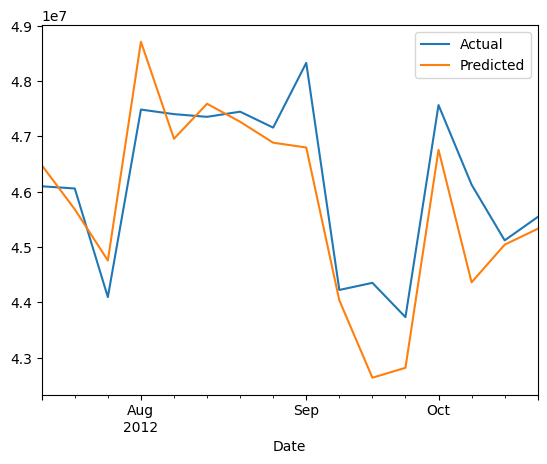

In [183]:
test_lr = test_lr.rename(columns={"Weekly_Sales":"Actual"})
test_lr.set_index("Date")[['Actual', "Predicted"]].plot()

In [184]:
print("MAE Linear Regression:",mae(test_lr['Actual'], test_lr['Predicted']))
print("MAPE Linear Regression:",round(mape(test_lr['Actual'], test_lr['Predicted'])*100,2), "%")
print("")

print("MAE Prophet:",mae(prophet_test_data['Actual'], prophet_test_data['Predicted']))
print("MAPE Prophet:",round(mape(prophet_test_data['Actual'], prophet_test_data['Predicted'])*100,2), "%")
print("")

print("MAE Prophet Best Model:",mae(prophet_test_data['Actual'], prophet_test_data['best_model_Predicted']))
print("MAPE Prophet:",round(mape(prophet_test_data['Actual'], prophet_test_data['best_model_Predicted'])*100,2), "%")

MAE Linear Regression: 686955.3810552084
MAPE Linear Regression: 1.49 %

MAE Prophet: 1045356.1874882174
MAPE Prophet: 2.27 %

MAE Prophet Best Model: 1012977.8789358535
MAPE Prophet: 2.23 %


Based on the MAPE and MAE scores, it makes sense to use LR for the prediction. Aggregating all the stores put in some noise and made forecasting not so clear. Perhaps the next steps will be to forecast based on stores. 